In [248]:
import time
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## Описание задачи:
плашка

плашка

плашка

плашка

плашка

---

## Технический блок.

## Содержание:
### - Парсер
### - Функция проверки стационарности ряда

### В данном блоке представлена функция парсера для сбора данных с сайта westmetall, который в свою очередь собирает данные с Лондонской Биржи Металлов (LME), решение собирать датасет со сторонней площадки обусловлено нижеследующими факторами:
    
    - LME с недавнего времени использует защиту CloudFlare обойти которую не получилось ни с помощью Selenium, ни с помощью sneak-парсеров, ни с помощью Scrapy, были перепробованы разные стратегии, не приведшие к результату.
    
    - Westmetall предоставляет верифицированные исторические данные, доступ к которым непосредственно на LME, закрыт пэйволом. Верификация подтверждается фактом работы с LME и Westmetall на протяжение 5-6 лет на нынешнем месте работы. 
    
    - В принципе я мог взять готовые датасеты из собственных наработок, но в таком случае не представилось бы возможности представить на суд парсер.
    

In [93]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])


# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-13,8353.0,8371.5,143.4
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85


,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
date,,,
2023-09-13,8353.0,8371.5,143.4
2023-09-12,8337.5,8365.0,135.65
2023-09-11,8332.5,8360.0,134.525
2023-09-08,8225.0,8242.0,134.125
2023-09-07,8242.5,8270.0,133.85


#### Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [257]:
# Создадим датафрейм для логирования результатов в разрезе метрика-тип модели,
# отметим, что логируются результаты ошибок на предсказании целевой переменной,
# т.е. LME Copper Cash-Settlement.
log_df = pd.DataFrame(columns=['baseline AR'], index=['rmse', 'mae', 'mape'])
log_df

,baseline AR
rmse,NaN
mae,NaN
mape,NaN


In [204]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = sm.tsa.adfuller(data)
    p_value = test[1]
    crit_value = test[4][crit_value]
    if p_value < crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [254]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    print(
        f'RMSE для {name}: {np.sqrt(mean_squared_error(test_df, pred_df)).round(3)}')

    # По MAE
    print(
        f'MAE для {name}: {mean_absolute_error(test_df, pred_df).round(3)}')

    # По MAPE
    print(
        f'MAPE для s{name}: {mean_absolute_percentage_error(test_df, pred_df).round(3)*100}%')


---

## Часть 0.

### Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [129]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col=['date'])

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,2706.000000,2706.000000,2706.000000
mean,6864.267184,6868.009978,233.463091
std,1485.842479,1479.619958,127.408463
min,0.000000,0.000000,0.000000
25%,5811.250000,5829.125000,143.518750
50%,6698.000000,6689.000000,217.325000
75%,7776.250000,7776.625000,299.400000
max,10730.000000,10720.000000,678.225000


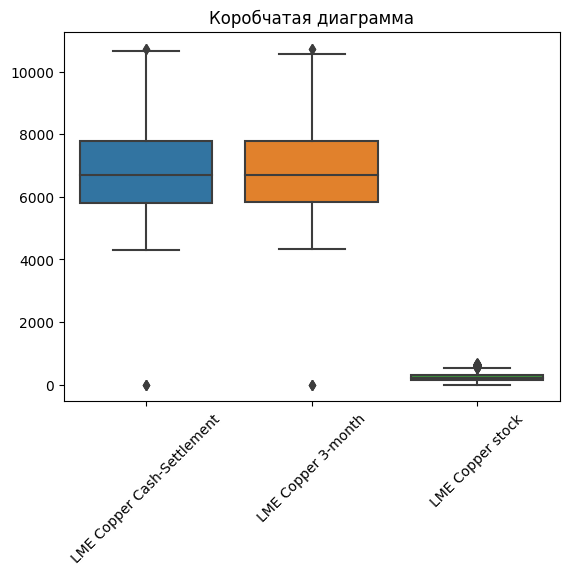

In [130]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
count,2702.000000,2702.000000,2702.000000
mean,6872.332346,6876.072354,233.550786
std,1469.035630,1462.718423,127.400718
min,4310.500000,4320.500000,51.175000
25%,5814.000000,5831.625000,143.518750
50%,6700.750000,6689.500000,217.512500
75%,7777.375000,7781.875000,299.400000
max,10730.000000,10720.000000,678.225000


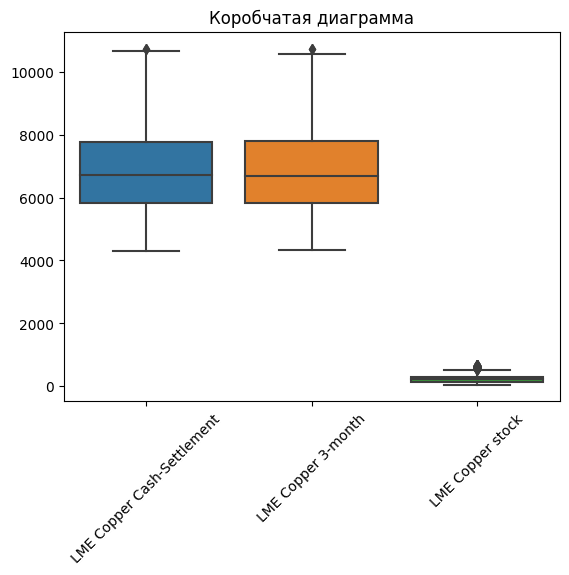

In [131]:
# Мы видим наличие нулевых значений
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

In [132]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [133]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data['LME Copper 3-month'] = data['LME Copper 3-month'].shift(90)

# Обрежем 13 год, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2013]

display(data.head(), data.tail())

,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
364,2014-01-01,7417.000000,7245.5,365.700000
365,2014-01-02,7439.500000,7182.0,365.700000
366,2014-01-03,7335.500000,7189.5,359.075000
367,2014-01-04,7328.166667,7197.0,358.091667
368,2014-01-05,7320.833333,7204.5,357.108333


,date,LME Copper Cash-Settlement,LME Copper 3-month,LME Copper stock
85,2023-12-07,NaN,8281.333333,NaN
86,2023-12-08,NaN,8320.666667,NaN
87,2023-12-09,NaN,8360.000000,NaN
88,2023-12-10,NaN,8365.000000,NaN
89,2023-12-11,NaN,8371.500000,NaN


Диапазон планирования равен 90 дней


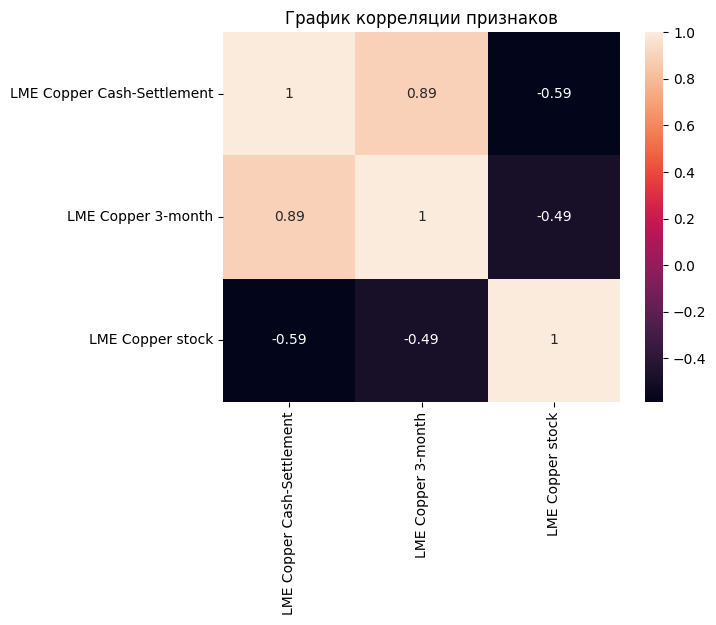

In [226]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data['LME Copper stock'].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data['LME Copper stock'].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

#### Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.
#### Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.
#### Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

## Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [222]:
# Будем прогнозировать временной ряд LME Copper stock и 
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data['LME Copper stock']
spot = working_data['LME Copper Cash-Settlement']

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)


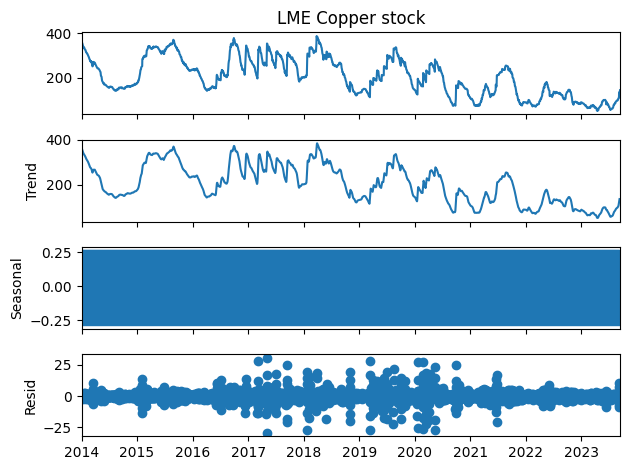

In [225]:
decompose_stock.plot()
plt.show()

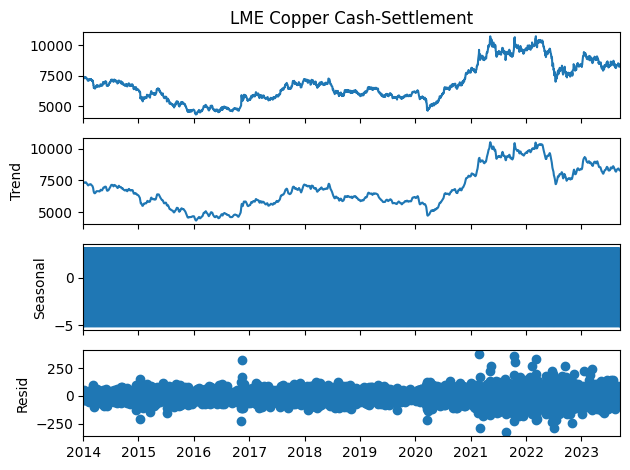

In [224]:
decompose_spot.plot()
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.


---

Единичных корней нет, ряд стационарен
{'p_value': 0.025345575686326286, 'crit_value (5%)': -2.862357963491113}
Единичных корней нет, ряд стационарен
{'p_value': 0.6391878656483765, 'crit_value (5%)': -2.862356807695006}


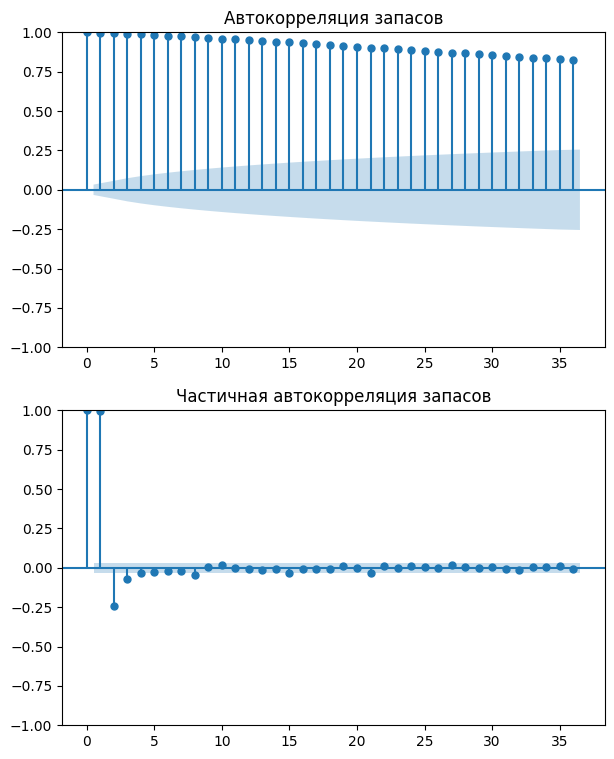

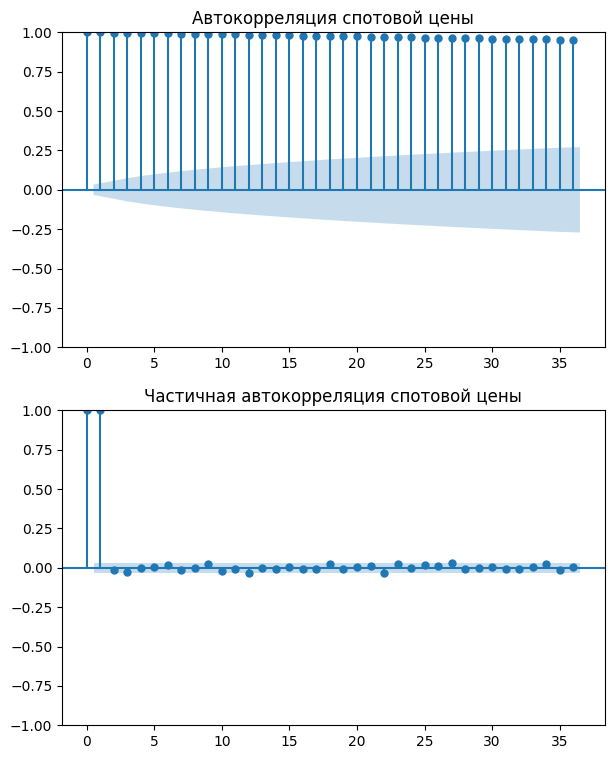

In [205]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock, name='запасов')
stationary_test(spot, name='спотовой цены')

> Вывод: оба ряда стационарны, диффиренцирование не требуется.

> p для запасов равен 2 (исходя из pacf графика)

> p для спота равен 1 (так же исходя из pacf)

In [207]:
p_stock = 2
p_spot = 1

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [232]:
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

In [239]:
ar_model_stock = AutoReg(train_stock, lags=p_stock).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot).fit()

In [240]:
pred_ar_stock = ar_model_stock.predict(start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

In [256]:
# Оценим baseline по rmse, mae и mape
metrics_calculation(test_stock, pred_ar_stock, name='stock-прогноза')
print('')
metrics_calculation(test_spot, pred_ar_spot, name='spot-прогноза')

RMSE для stock-прогноза: 18.791
MAE для stock-прогноза: 15.115
MAPE для sstock-прогноза: 20.7%

RMSE для spot-прогноза: 131.689
MAE для spot-прогноза: 105.783
MAPE для sspot-прогноза: 1.3%


> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый результат для baseline модели.

---